# MultiLayer Perceptron Neural Network trained on MNIST using JAX

In [1]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, pmap, grad, value_and_grad,

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [3]:
seed = 0
mnist_img_size = (28, 28)

def init_MLP(layer_widths, parent_key, scale=0.01):

    params = []
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
                       scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
                       scale*jax.random.normal(bias_key, shape=(out_width,))
                       ]
        )

    return params

# test
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784, 512, 256, 10], key)
print(jax.tree_map(lambda x: x.shape, MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


<ipython-input-3-84ead1774dfc>:22: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  print(jax.tree_map(lambda x: x.shape, MLP_params))


In [4]:
def MLP_predict(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last

   
    return logits - logsumexp(logits)

# tests

dummy_img_flat = np.random.randn(np.prod(mnist_img_size))
print(dummy_img_flat.shape)

prediction = MLP_predict(MLP_params, dummy_img_flat)
print(prediction.shape)

# test 
batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0))

dummy_imgs_flat = np.random.randn(16, np.prod(mnist_img_size))
print(dummy_imgs_flat.shape)
predictions = batched_MLP_predict(MLP_params, dummy_imgs_flat)
print(predictions.shape)

(784,)
(10,)
(16, 784)
(16, 10)


In [5]:
def custom_transform(x):
    return np.ravel(np.array(x, dtype=np.float32))

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

batch_size = 128
train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization 
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3404148.06it/s]


Extracting train_mnist/MNIST/raw/train-images-idx3-ubyte.gz to train_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 159451.59it/s]


Extracting train_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to train_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1510481.67it/s]


Extracting train_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to train_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3271038.59it/s]


Extracting train_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to train_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5475047.02it/s] 


Extracting test_mnist/MNIST/raw/train-images-idx3-ubyte.gz to test_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 159632.51it/s]


Extracting test_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to test_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:05<00:00, 311893.34it/s]


Extracting test_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to test_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8085962.97it/s]


Extracting test_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to test_mnist/MNIST/raw

(128, 784) float32 (128,) int64


In [8]:
num_epochs = 5

def loss_fn(params, imgs, gt_lbls):
    predictions = batched_MLP_predict(params, imgs)

    return -jnp.mean(predictions * gt_lbls)

def accuracy(params, dataset_imgs, dataset_lbls):
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)

    return loss, jax.tree_map(lambda p, g: p - lr*g, params, grads)

# Create a MultiLayer Perceptron Neural Network
MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

for epoch in range(num_epochs):

    for cnt, (imgs, lbls) in enumerate(train_loader):

        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))

        loss, MLP_params = update(MLP_params, imgs, gt_labels)

        if cnt % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} test acc = {accuracy(MLP_params, test_images, test_lbls)}')


<ipython-input-8-542691f42cde>:16: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return loss, jax.tree_map(lambda p, g: p - lr*g, params, grads)


0.24393414
0.09278781
0.05554725
0.04945897
0.036542695
0.031824328
0.031886894
0.032048665
0.043751117
0.027346892
Epoch 0, train acc = 0.9127833247184753 test acc = 0.915399968624115
0.0330791
0.03518331
0.023511922
0.022733787
0.028340692
0.028637964
0.014767967
0.024988228
0.02067462
0.021632621
Epoch 1, train acc = 0.9294999837875366 test acc = 0.9273999929428101
0.03089915
0.015393085
0.026990956
0.020079613
0.019876808
0.023556236
0.028148223
0.01763413
0.0074439137
0.019702353
Epoch 2, train acc = 0.946066677570343 test acc = 0.9432999491691589
0.014589104
0.031496603
0.031871594
0.021957915
0.010244899
0.014682106
0.016560981
0.020247957
0.012045608
0.015079287
Epoch 3, train acc = 0.9517833590507507 test acc = 0.9484999775886536
0.022452602
0.009430892
0.008511185
0.019248879
0.012257467
0.007379682
0.015125506
0.009523469
0.0077245156
0.017473063
Epoch 4, train acc = 0.9583666920661926 test acc = 0.9548999667167664


(28, 28)
pred 1
gt 1


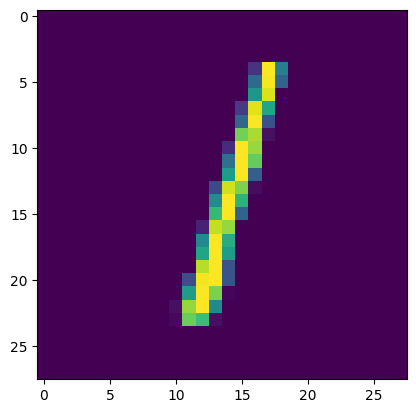

In [12]:
imgs, lbls = next(iter(test_loader))
img = imgs[2].reshape(mnist_img_size)
gt_lbl = lbls[2]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
print('pred', pred)
print('gt', gt_lbl)

plt.imshow(img); plt.show()

# Visualizations

(512, 784)
(28, 28)


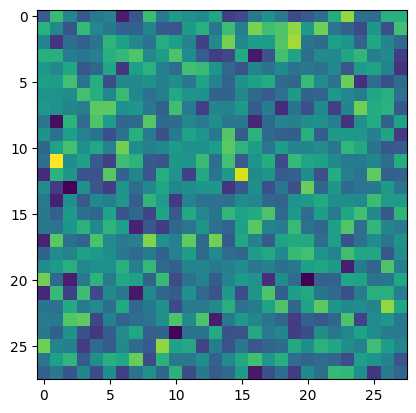

In [13]:
w = MLP_params[0][0]
print(w.shape)

w_single = w[500, :].reshape(mnist_img_size)
print(w_single.shape)
plt.imshow(w_single); plt.show()

(128, 256)


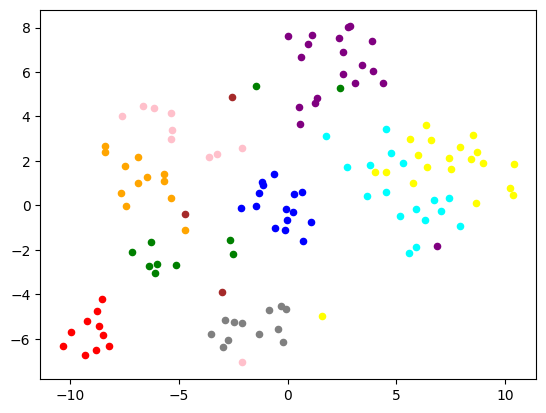

In [15]:
# todo: visualize embeddings using t-SNE

from sklearn.manifold import TSNE

def fetch_activations(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    return activation

batched_fetch_activations = vmap(fetch_activations, in_axes=(None, 0))
imgs, lbls = next(iter(test_loader))

batch_activations = batched_fetch_activations(MLP_params, imgs)
print(batch_activations.shape)  # (128, 2)

t_sne_embeddings = TSNE(n_components=2, perplexity=30,).fit_transform(batch_activations)
cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray", 7: "purple", 8: "brown", 9: "cyan"}

for class_id in range(10):
    plt.scatter(t_sne_embeddings[lbls == class_id, 0], t_sne_embeddings[lbls == class_id, 1], s=20, color=cora_label_to_color_map[class_id])
plt.show()

In [16]:


def fetch_activations2(params, x):
    hidden_layers = params[:-1]
    collector = []

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)
        collector.append(activation)

    return collector

batched_fetch_activations2 = vmap(fetch_activations2, in_axes=(None, 0))

imgs, lbls = next(iter(test_loader))

MLP_params2 = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

batch_activations = batched_fetch_activations2(MLP_params2, imgs)
print(batch_activations[1].shape)  # (128, 512/256)

dead_neurons = [np.ones(act.shape[1:]) for act in batch_activations]

for layer_id, activations in enumerate(batch_activations):
    dead_neurons[layer_id] = np.logical_and(dead_neurons[layer_id], (activations == 0).all(axis=0))

for layers in dead_neurons:
    print(np.sum(layers))

(128, 256)
0
7
